In [1]:
import dill
from train_valid_test_loader import load_train_valid_test_datasets

In [2]:
dill_file = open('k=2Dec4Model', 'rb')
best_colab_model = dill.load(dill_file)
dill_file.close()

In [3]:
best_colab_model

In [4]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
        load_train_valid_test_datasets()

[    0     1     2 ... 89989 89990 89991]


In [5]:
print(train_tuple)

(array([662, 298,  90, ..., 574, 757, 503]), array([761,  90, 349, ..., 505, 472, 204]), array([5, 4, 4, ..., 2, 5, 3]))


In [24]:
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
df_user = pd.read_csv('data_movie_lens_100k/user_info.csv')
df_movie = pd.read_csv('data_movie_lens_100k/movie_info.csv')
df_test_ratings = pd.read_csv('data_movie_lens_100k/ratings_masked_leaderboard_set.csv')
movies_raw = list(df_movie['title'].values)
bad_chars = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '(', ')', 'The', ',']
movies = []
for movie in movies_raw:
    for c in bad_chars:
        movie = movie.replace(c, '')
    movies.append(movie)
title_count = CountVectorizer().fit_transform(movies).toarray()
test_users_ids = df_test_ratings['user_id']
test_movie_ids = df_test_ratings['item_id']


In [32]:
y_true_train = []
x_vals_train = []
scaler = MinMaxScaler()
for u, m, r in zip(train_tuple[0], train_tuple[1], train_tuple[2]):
    x = [title_count[m].tolist() + [df_movie['release_year'][m]] + [df_user['age'][u]] + [df_user['is_male'][u]]]
    y_true_train.append(r)
    x_vals_train.append(x)
y_true_train = np.asarray(y_true_train).squeeze()
x_vals_train = np.asarray(x_vals_train).squeeze()
x_vals_train = scaler.fit_transform(x_vals_train)

[[0.97368421 0.28787879 1.        ]
 [0.93421053 0.33333333 1.        ]
 [1.         0.72727273 1.        ]
 ...
 [0.38157895 0.39393939 1.        ]
 [0.53947368 0.3030303  1.        ]
 [0.63157895 0.5        0.        ]]


In [33]:
y_true_valid = []
x_vals_valid = []
scaler = MinMaxScaler()
for u, m, r in zip(valid_tuple[0], valid_tuple[1], valid_tuple[2]):
    x = [ title_count[m].tolist() + [df_movie['release_year'][m]] + [df_user['age'][u]] + [df_user['is_male'][u]]]
    y_true_valid.append(r)
    x_vals_valid.append(x)
y_true_valid = np.asarray(y_true_valid).squeeze()
x_vals_valid = np.asarray(x_vals_valid).squeeze()
x_vals_valid = scaler.fit_transform(x_vals_valid)

In [37]:
MAE_train = []
MAE_valid = []
alphas = np.logspace(-8, 4, 13)
for alpha in alphas:
    print(alpha)
    model = Lasso(alpha=alpha, random_state=123453)
    model.fit(x_vals_train, y_true_train)
    y_hat_train = model.predict(x_vals_train)
    y_hat_valid = model.predict(x_vals_valid)
    MAE_train.append(mean_absolute_error(y_true_train, y_hat_train))
    MAE_valid.append(mean_absolute_error(y_true_valid, y_hat_valid))

1e-08


/Users/davidshapiro/micromamba/envs/cs135_25f_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+04, tolerance: 8.872e+00
  model = cd_fast.enet_coordinate_descent(


1e-07


/Users/davidshapiro/micromamba/envs/cs135_25f_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e+04, tolerance: 8.872e+00
  model = cd_fast.enet_coordinate_descent(


1e-06


/Users/davidshapiro/micromamba/envs/cs135_25f_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.081e+04, tolerance: 8.872e+00
  model = cd_fast.enet_coordinate_descent(


1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


[3.3936747  3.44421737 3.46796459 ... 4.01944606 3.8381757  3.80692407]
0.9235411538512621


Text(0.5, 1.0, 'MAE across alpha values')

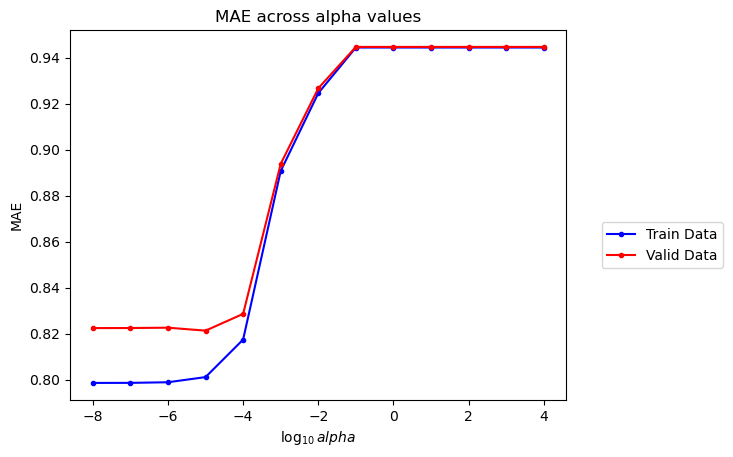

In [38]:
plt.plot(np.log10(alphas), MAE_train, '.-', color='blue', label='Train Data')
plt.plot(np.log10(alphas), MAE_valid, '.-', color='red', label='Valid Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("$\log_{10} alpha$")
plt.title("MAE across alpha values")